In [2]:
#Import libraries and load data
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.experimental import enable_hist_gradient_boosting  # for HistGradientBoosting
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.impute import SimpleImputer



In [3]:
# Load datasets
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [4]:
# Separate target
y = np.log1p(train['SalePrice'])  # log-transform
X = train.drop(['SalePrice', 'Id'], axis=1)

In [5]:
#Check missing values
missing_counts = X.isnull().sum().sort_values(ascending=False)
missing_counts[missing_counts > 0]


PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
LotFrontage      259
GarageQual        81
GarageFinish      81
GarageType        81
GarageYrBlt       81
GarageCond        81
BsmtFinType2      38
BsmtExposure      38
BsmtQual          37
BsmtCond          37
BsmtFinType1      37
MasVnrArea         8
Electrical         1
dtype: int64

In [7]:
#Impute missing values
#Numeric → median
#Categorical → most frequent
num_cols = X.select_dtypes(include=['int64','float64']).columns
cat_cols = X.select_dtypes(include=['object']).columns

numeric_imputer = SimpleImputer(strategy='median')
categorical_imputer = SimpleImputer(strategy='most_frequent')

preprocessor = ColumnTransformer([
    ('num', numeric_imputer, num_cols),
    ('cat', Pipeline([
        ('imputer', categorical_imputer),
        ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ]), cat_cols)
])


In [8]:
#Define the model pipeline
model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', HistGradientBoostingRegressor(
        max_iter=1000,
        learning_rate=0.03,
        max_depth=3,
        random_state=42
    ))
])


In [9]:
#Train-test split (for validation)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

model.fit(X_train, y_train)

# Validate
y_val_pred = model.predict(X_val)
rmse_val = np.sqrt(np.mean((y_val_pred - y_val)**2))
rmse_val


np.float64(0.13419914125872093)

In [10]:
#Train on full dataset and predict test set
# Fit on full training data
model.fit(X, y)

# Prepare test set
X_test = test.drop(['Id'], axis=1)

# Predict log-sale prices
y_test_pred_log = model.predict(X_test)

# Convert back to original SalePrice
y_test_pred = np.expm1(y_test_pred_log)

# Prepare submission
submission = test[['Id']].copy()
submission['SalePrice'] = y_test_pred

# Save
submission.to_csv("submission.csv", index=False)
submission.head()


,Id,SalePrice
0,1461,122568.340597
1,1462,152618.663392
2,1463,179158.179815
3,1464,192378.749212
4,1465,186402.774573


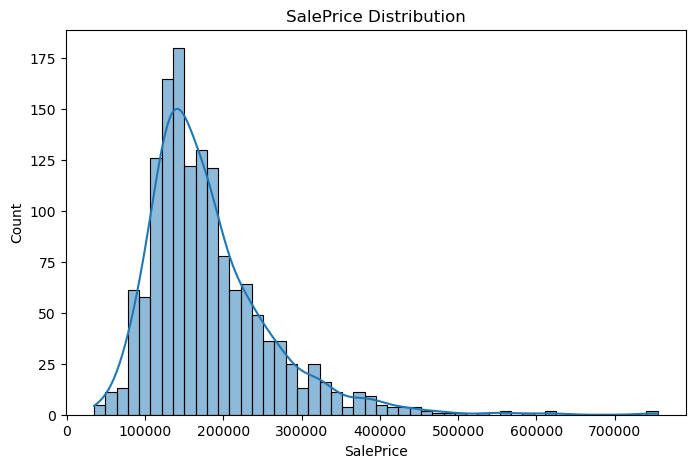

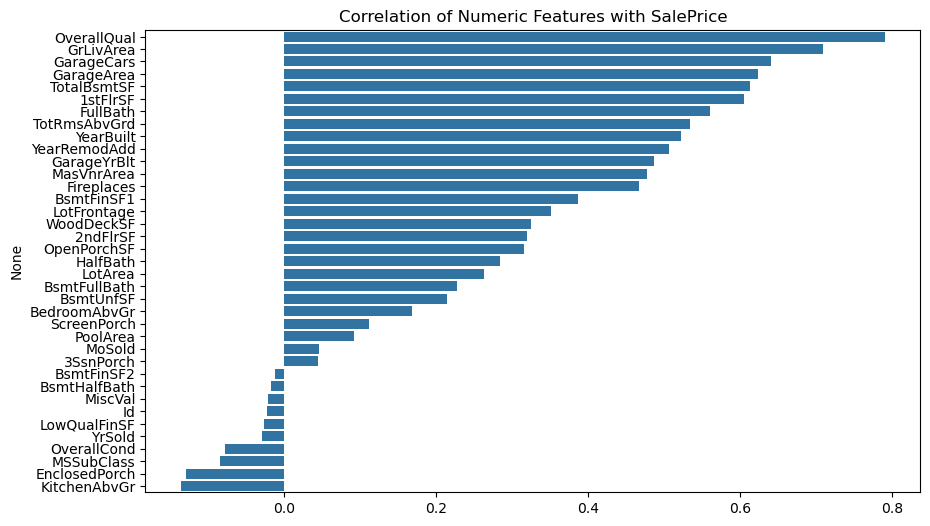

In [11]:
#Visualize numeric features & SalePrice
import matplotlib.pyplot as plt
import seaborn as sns

# Plot SalePrice distribution
plt.figure(figsize=(8,5))
sns.histplot(train['SalePrice'], kde=True, bins=50)
plt.title("SalePrice Distribution")
plt.show()

# Plot numeric feature correlations with SalePrice
num_cols = train.select_dtypes(include=['int64','float64']).columns.drop('SalePrice')
corr = train[num_cols].corrwith(train['SalePrice']).sort_values(ascending=False)
plt.figure(figsize=(10,6))
sns.barplot(x=corr.values, y=corr.index)
plt.title("Correlation of Numeric Features with SalePrice")
plt.show()


In [12]:
#Handle outliers
# Remove outliers based on GrLivArea and TotalBsmtSF
train = train[train['GrLivArea'] < 4500]
train = train[train['TotalBsmtSF'] < 3000]

# Update X and y
y = np.log1p(train['SalePrice'])
X = train.drop(['SalePrice','Id'], axis=1)


In [14]:
#Handle missing values
num_cols = X.select_dtypes(include=['int64','float64']).columns
cat_cols = X.select_dtypes(include=['object']).columns

numeric_imputer = SimpleImputer(strategy='median')
categorical_imputer = SimpleImputer(strategy='most_frequent')

preprocessor = ColumnTransformer([
    ('num', numeric_imputer, num_cols),
    ('cat', Pipeline([
        ('imputer', categorical_imputer),
        ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ]), cat_cols)
])


In [15]:
#Define model pipeline
model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', HistGradientBoostingRegressor(
        max_iter=1000,
        learning_rate=0.03,
        max_depth=3,
        random_state=42
    ))
])


In [16]:
#Train-test split for validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

model.fit(X_train, y_train)

# Validate
y_val_pred = model.predict(X_val)
rmse_val = np.sqrt(np.mean((y_val_pred - y_val)**2))
rmse_val


np.float64(0.11996162285172193)

In [17]:
#Train on full dataset and predict test set
model.fit(X, y)

X_test = test.drop(['Id'], axis=1)
y_test_pred_log = model.predict(X_test)
y_test_pred = np.expm1(y_test_pred_log)

submission = test[['Id']].copy()
submission['SalePrice'] = y_test_pred
submission.to_csv("submission.csv", index=False)
submission.head()


,Id,SalePrice
0,1461,122195.406503
1,1462,150466.219980
2,1463,181232.337568
3,1464,193722.295403
4,1465,189387.747872


In [28]:
#Feature Selection
from sklearn.feature_selection import mutual_info_regression
from sklearn.impute import SimpleImputer
import pandas as pd

# Select numeric columns
X_num = X.select_dtypes(include=['int64', 'float64'])

# Impute missing values with median
imputer_num = SimpleImputer(strategy='median')
X_num_imputed = pd.DataFrame(imputer_num.fit_transform(X_num), columns=X_num.columns)

# Compute mutual information scores
mi_scores = mutual_info_regression(X_num_imputed, y)
mi_scores = pd.Series(mi_scores, index=X_num.columns).sort_values(ascending=False)

top_num_features = mi_scores.head(20).index.tolist()
print("Top numeric features:", top_num_features)


Top numeric features: ['OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea', 'TotalBsmtSF', 'YearBuilt', '1stFlrSF', 'GarageYrBlt', 'MSSubClass', 'FullBath', 'YearRemodAdd', 'LotFrontage', 'TotRmsAbvGrd', '2ndFlrSF', 'LotArea', 'Fireplaces', 'OpenPorchSF', 'BsmtFinSF1', 'BsmtUnfSF', 'OverallCond']


In [30]:
# 2. Categorical features
# Select only those with high correlation to SalePrice
# Encode first for mutual info
X_cat = X.select_dtypes(include=['object'])
X_cat_filled = X_cat.fillna('Missing')
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import SelectKBest
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
X_cat_encoded = ohe.fit_transform(X_cat_filled)


In [39]:
from sklearn.feature_selection import SelectKBest, mutual_info_regression
import numpy as np

# One-hot encode categorical features
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
X_cat_encoded = ohe.fit_transform(X_cat_filled)

# Get feature names after encoding
encoded_feature_names = ohe.get_feature_names_out(X_cat.columns)

# Select top K encoded categorical features
selector = SelectKBest(score_func=mutual_info_regression, k=20)
selector.fit(X_cat_encoded, y)

# Get selected encoded feature names
selected_encoded_features = encoded_feature_names[selector.get_support()]

# Map back to original categorical column names
top_cat_features = list(
    set(feature.split('_')[0] for feature in selected_encoded_features)
)

print("Top categorical features:", top_cat_features)


Top categorical features: ['BsmtQual', 'BsmtFinType1', 'FireplaceQu', 'LotShape', 'Exterior2nd', 'HeatingQC', 'GarageType', 'Foundation', 'ExterQual', 'KitchenQual', 'GarageFinish']


In [40]:
#Update Preprocessor with selected features only
# Keep only selected features
numeric_selected = top_num_features
categorical_selected = [col.split('_')[0] for col in top_cat_features]  # get original column names

# Remove duplicates
categorical_selected = list(set(categorical_selected))

preprocessor_fs = ColumnTransformer([
    ('num', numeric_imputer, numeric_selected),
    ('cat', Pipeline([
        ('imputer', categorical_imputer),
        ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ]), categorical_selected)
])


In [41]:
#Build pipeline and train
model_fs = Pipeline([
    ('preprocessor', preprocessor_fs),
    ('regressor', HistGradientBoostingRegressor(
        max_iter=1000,
        learning_rate=0.03,
        max_depth=3,
        random_state=42
    ))
])

# Train-validation split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

model_fs.fit(X_train, y_train)

# Validate
y_val_pred = model_fs.predict(X_val)
rmse_val = np.sqrt(np.mean((y_val_pred - y_val)**2))
rmse_val


np.float64(0.1289958103447948)

In [42]:
#Train full model & predict test set
model_fs.fit(X, y)

X_test_fs = test.drop(['Id'], axis=1)
y_test_pred_log = model_fs.predict(X_test_fs)
y_test_pred = np.expm1(y_test_pred_log)

submission = test[['Id']].copy()
submission['SalePrice'] = y_test_pred
submission.to_csv("submission_feature_selected.csv", index=False)
submission.head()


,Id,SalePrice
0,1461,125374.341691
1,1462,155546.441891
2,1463,184682.863506
3,1464,191982.768914
4,1465,185580.503590


In [47]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import HistGradientBoostingRegressor

# Separate features
num_cols = X.select_dtypes(include=['int64','float64']).columns
cat_cols = X.select_dtypes(include=['object']).columns

# Preprocessing
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_cols),
        ('cat', categorical_transformer, cat_cols)
    ]
)

# Model
model = HistGradientBoostingRegressor(random_state=42)

# FULL pipeline
model_fs = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', model)
])


In [48]:
from sklearn.model_selection import RandomizedSearchCV

param_grid = {
    'model__max_iter': [500, 800, 1000],
    'model__learning_rate': [0.01, 0.03, 0.05],
    'model__max_depth': [3, 4, 5],
    'model__max_bins': [64, 128, 255],
    'model__l2_regularization': [0.0, 0.1, 1.0]
}

random_search = RandomizedSearchCV(
    estimator=model_fs,
    param_distributions=param_grid,
    n_iter=30,
    scoring='neg_root_mean_squared_error',
    cv=5,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X, y)

print("Best Parameters:", random_search.best_params_)
print("Best RMSE:", -random_search.best_score_)


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best Parameters: {'model__max_iter': 1000, 'model__max_depth': 3, 'model__max_bins': 255, 'model__learning_rate': 0.03, 'model__l2_regularization': 1.0}
Best RMSE: 0.11894827039810488


In [53]:
from sklearn.feature_selection import SelectKBest, mutual_info_regression
import numpy as np

# One-hot encode categorical features
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
X_cat_encoded = ohe.fit_transform(X_cat_filled)

# Get feature names after encoding
encoded_feature_names = ohe.get_feature_names_out(X_cat.columns)

# Select top K encoded categorical features
selector = SelectKBest(score_func=mutual_info_regression, k=20)
selector.fit(X_cat_encoded, y)

# Get selected encoded feature names
selected_encoded_features = encoded_feature_names[selector.get_support()]

# Map back to original categorical column names
top_cat_features = list(
    set(feature.split('_')[0] for feature in selected_encoded_features)
)

print("Top categorical features:", top_cat_features)


Top categorical features: ['BsmtQual', 'BsmtFinType1', 'FireplaceQu', 'LotShape', 'Exterior2nd', 'HeatingQC', 'GarageType', 'Foundation', 'ExterQual', 'KitchenQual', 'GarageFinish']


In [54]:
#Extract the best model from tuning
best_model = random_search.best_estimator_


In [55]:
#Train best model on FULL training data
best_model.fit(X, y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'Bs...
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object'))])),
                ('model',
                 HistGradientBoostingRegressor(l2_regularization=1.0,
                                               learning_rate=0.03, max_depth=3,
                                               max_iter=1000,
                                               random_state=42))])

In [56]:
# Reload test set if needed
test = pd.read_csv("test.csv")

test_ids = test['Id']
X_test = test.drop(columns=['Id'])

In [57]:
# Predict log SalePrice
test_pred_log = best_model.predict(X_test)

# Convert back to SalePrice
test_pred = np.expm1(test_pred_log)

In [58]:
submission = pd.DataFrame({
    'Id': test_ids,
    'SalePrice': test_pred
})

submission.to_csv("submission 2.csv", index=False)

In [60]:
submission.head()
submission.describe()

,Id,SalePrice
count,1459.000000,1459.000000
mean,2190.000000,178096.890577
std,421.321334,79170.158154
min,1461.000000,44709.993336
25%,1825.500000,127667.007066
50%,2190.000000,156932.240636
75%,2554.500000,209866.579587
max,2919.000000,643188.266677
